This book serves as a model for the rest of the python books submitted. Each book follows the same order of operations, only with slightly different methods. Each books main use will be explained in it's first cell, however this book will explain each cell on a step by step method. 

Normalization Book:
- This book is testing the usefulness of normalizing the data fed into Darwin.
- Following two cells are responsible for importing necessary libraries and logging into Darwin. 

In [47]:

# Import necessary libraries
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from amb_sdk.sdk import DarwinSdk

In [48]:
ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('piercejkotarski@utexas.edu', '7bA3rFFMcM')

if not status:
    print(msg)

Data Cleaning and Feature Engineering: 
 - In the following cell we cleaned our original csv file full of NBA team data.
 - Not only did we modify the names of some statistics for ease of use, we also created a new statistics in win  percentage. 

In [49]:
dataset_name = 'nba_data.csv' #we're going to run three simultaneous datasets through darwin, all using this set. 
data = pd.read_csv(dataset_name)

data['Playoff result'].replace(0, "NP", inplace = True)  # No playoffs
data['Playoff result'].replace(1, "FR", inplace = True)  # Lost in first round
data['Playoff result'].replace(2, "SF", inplace = True)  # Lost in semi-finals
data['Playoff result'].replace(3, "CF", inplace = True)  # Lost in conference finals
data['Playoff result'].replace(4, "LF", inplace = True)  # Lost in finals
data['Playoff result'].replace(5, "WF", inplace = True)  # Won finals



data = data.rename(index=str, columns={"Games": "G", "Wins": "W", "Losses": "L","# of teams in league": "NUM_TEAMS", 
                                       "Playoff result": "Result", "Mean Age": "Age"})

data["WIN_PCT"] = data['W'] / data['G']
data.drop(['W', 'L', 'PW', 'PL', 'NUM_TEAMS', '2P', '2PA', 'NRtg', "FG", '3P', '3PA', 'TOV', 'SRS'], axis = 1, inplace = True)

data = data[data['G'] >= 81]

cols = [col for col in data.columns if col not in ['Team', 'Result', 'NUM_TEAMS', 'G', 'W', 'L', 'PW', 'PL', 'WIN_PCT']]
data.head()

,Team,Year,Result,G,MP,FGA,FG%,3P%,2P%,FT,...,TS%,OeFG%,OTOV%,ORB%,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,WIN_PCT
0,Atlanta Hawks,1983,FR,82,242.1,83.0,0.474,0.217,0.478,22.4,...,0.529,0.476,14.4,31.6,0.270,0.482,15.1,65.2,0.268,0.487805
1,Boston Celtics,1983,WF,82,243.4,88.2,0.500,0.240,0.508,23.3,...,0.554,0.504,14.6,34.2,0.264,0.475,13.8,69.7,0.225,0.756098
2,Chicago Bulls,1983,NP,82,243.7,85.0,0.474,0.171,0.479,22.8,...,0.526,0.475,16.3,32.3,0.268,0.497,15.6,67.2,0.266,0.329268
3,Cleveland Cavaliers,1983,NP,82,242.1,88.2,0.465,0.262,0.470,19.7,...,0.512,0.468,14.0,33.5,0.224,0.490,13.2,70.8,0.280,0.341463
4,Dallas Mavericks,1983,SF,82,243.4,88.2,0.500,0.228,0.507,21.6,...,0.547,0.503,13.6,31.7,0.245,0.503,14.4,65.7,0.232,0.524390


Transformation Cell:
 - As mentioned previously, we attempted a different method with each of the three books we are using:
     - Normalization
     - Standardization
     - Focus on Specific Data
 - The following cell uses normalization to modify the data before it is fed into Darwin. The other books use another of the three methods.

In [50]:
out = ['Team', 'Result', 'G', 'WIN_PCT']


data_norm = data[cols].groupby('Year').transform(lambda x: ((x-x.min()) / (x.max() - x.min())))
data_norm[out] = data[out]

Train and Test Data:
 - This cell splits our training and testing Data to be fed into Darwin.
 - The cell beneath it writes both datasets into CSV files, which Darwin requires. 

In [51]:
train_norm, test_norm = train_test_split(data_norm, test_size = 0.2)

In [52]:
test_norm.to_csv(path_or_buf = "test_norm.csv")
train_norm.to_csv(path_or_buf = "train_norm.csv")

norm_name = 'train_norm.csv'

Upload Dataset to Darwin and Clean Data:

In [54]:

status, dataset_norm = ds.upload_dataset(norm_name)
if not status:
    print(dataset_norm)

In [55]:
target = "Result"
status, job_id = ds.clean_data(norm_name, target = target)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T17:06:14.752116', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_norm.csv'], 'artifact_names': ['cd714681711145ab9c2f6976fa4a3a7a'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-23T17:06:14.752116', 'endtime': '2019-04-23T17:06:18.324654', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['train_norm.csv'], 'artifact_names': ['cd714681711145ab9c2f6976fa4a3a7a'], 'model_name': None, 'job_error': ''}


Create Model, Train in Darwin and Retrieve Info from the Model:

In [56]:

model_norm = target + "_model_norm"

status, job_id = ds.create_model(dataset_names = norm_name, \
                                 model_name =  model_norm, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T17:07:54.503183', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['train_norm.csv'], 'artifact_names': None, 'model_name': 'Result_model_norm', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-23T17:07:54.503183', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 1.409950613975525, 'generations': 3, 'dataset_names': ['train_norm.csv'], 'artifact_names': None, 'model_name': 'Result_model_norm', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:07:54.503183', 'endtime': None, 'percent_complete': 3, 'job_type': 'TrainModel', 'loss': 1.409950613975525, 'generations': 3, 'dataset_names': ['train_norm.csv'], 'artifact_names': None, 'model_name': 'Result_model_norm', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:07:54.503183', 'endtime': None, 'percent_complete': 20, 'job_type': 'TrainModel', 'loss': 1.

In [57]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = norm_name,
                                          model_name = model_norm,
                                          max_train_time = '00:05')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-23T17:10:22.384878', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.7372937798500061, 'generations': 7, 'dataset_names': ['train_norm.csv'], 'artifact_names': None, 'model_name': 'Result_model_norm', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-23T17:10:22.384878', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.7372937798500061, 'generations': 7, 'dataset_names': ['train_norm.csv'], 'artifact_names': None, 'model_name': 'Result_model_norm', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:10:22.384878', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.7372937798500061, 'generations': 7, 'dataset_names': ['train_norm.csv'], 'artifact_names': None, 'model_name': 'Result_model_norm', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-23T17:10:22.384878', 'endtime': None, 'percent_complete': 9, 'job_type': 'Updat

In [58]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model_norm)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-23T17:12:04.828088', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.7372937798500061, 'generations': 10, 'dataset_names': None, 'artifact_names': ['d655827413684f6189a8b45390a77a41'], 'model_name': 'Result_model_norm', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T17:12:04.828088', 'endtime': '2019-04-23T17:12:06.784988', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.7372937798500061, 'generations': 10, 'dataset_names': None, 'artifact_names': ['d655827413684f6189a8b45390a77a41'], 'model_name': 'Result_model_norm', 'job_error': ''}


Feature Importance:
 - The following cell displays feature importance, a very helpful standard for establishing which features might be eliminated on later tests. 
 - Throughout iterations of testing we used this cell to attempt to clean our data of unnecessary dimensions. 

In [59]:
feature_importance[:30]

WIN_PCT    0.220180
MOV        0.115313
DRtg       0.062244
ORtg       0.054024
DeFG%      0.046360
SOS        0.037617
OeFG%      0.029967
Age        0.028371
TS%        0.021473
PTS        0.021084
DRB        0.019674
FG%        0.018917
DTOV%      0.017811
2P%        0.017636
OTOV%      0.017620
OFT/FGA    0.015758
DRB%       0.015581
AST        0.014978
FGA        0.014740
DFT/FGA    0.014424
3PAr       0.013478
STL        0.013182
MP         0.013097
3P%        0.012941
FTA        0.012251
TRB        0.012024
FT%        0.011940
ORB        0.011781
Pace       0.011391
BLK        0.011036
dtype: float64

Running Model on Train Data:
 - The following cells run our model on the data that was just previously trained upon.
 - Although this test does not give a completely valid understanding of the models accuracy, it does give a glance into its ability. 

In [60]:
status, artifact = ds.run_model(norm_name, model_norm)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-23T17:12:46.176725', 'endtime': '2019-04-23T17:12:47.038516', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.7372937798500061, 'generations': 10, 'dataset_names': ['train_norm.csv'], 'artifact_names': ['7241579e8de74219913ee4ddccf034ec'], 'model_name': 'Result_model_norm', 'job_error': ''}


(True, 'Job completed')

In [61]:
status, prediction = ds.download_artifact(artifact['artifact_name'])
prediction.head()

,Result,prob_CF,prob_FR,prob_LF,prob_NP,prob_SF,prob_WF
0,NP,4.257700e-06,0.013022,4.515000e-07,0.986478,0.000494,2.503000e-07
1,FR,4.201590e-02,0.626395,1.881674e-02,0.018217,0.286200,8.355875e-03
2,SF,1.925146e-01,0.277833,1.104597e-01,0.002878,0.349211,6.710358e-02
3,NP,1.458500e-06,0.004215,1.517000e-07,0.995629,0.000154,9.640000e-08
4,NP,1.046000e-07,0.006856,5.000000e-09,0.993056,0.000087,1.900000e-09


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-macosx-10.6-intel.egg/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          CF       0.24      0.24      0.24        49
          FR       0.68      0.79      0.73       215
          LF       0.00      0.00      0.00        30
          NP       0.93      0.98      0.96       315
          SF       0.38      0.41      0.39       106
          WF       0.00      0.00      0.00        24

   micro avg       0.72      0.72      0.72       739
   macro avg       0.37      0.40      0.39       739
weighted avg       0.67      0.72      0.69       739



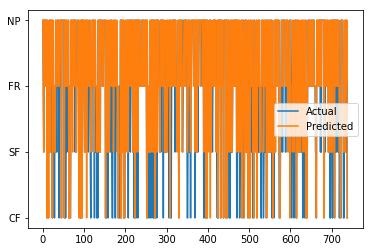

In [62]:
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(train_norm[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(train_norm[target], prediction[target]))

Testing on Previously Separated Data:
 - To test the true accuracy and ability of the model, it should be ran against previously separated test data. 
 - The following cells upload test data, clean the data, and run the model against it. 
 - The results, as anticipated, are slightly worse than the original tests on the training data. However, in all three cases the final results show the model to be an effect predictor. 

In [63]:
test_data = 'test_norm.csv'
status, dataset = ds.upload_dataset(test_data)
if not status:
    print(dataset)

In [64]:
# clean test dataset
status, job_id = ds.clean_data(test_data, target = target, model_name = model_norm)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Running', 'starttime': '2019-04-23T17:13:46.700644', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_norm.csv'], 'artifact_names': ['4cbdbb8ea6c6419b9d2087be0a45d293'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T17:13:46.700644', 'endtime': '2019-04-23T17:13:48.278534', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['test_norm.csv'], 'artifact_names': ['4cbdbb8ea6c6419b9d2087be0a45d293'], 'model_name': None, 'job_error': ''}


In [65]:
status, artifact = ds.run_model(test_data, model_norm)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Complete', 'starttime': '2019-04-23T17:14:09.877908', 'endtime': '2019-04-23T17:14:11.155222', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.7372937798500061, 'generations': 10, 'dataset_names': ['test_norm.csv'], 'artifact_names': ['c11d473d6a494c02b1b3127724695b97'], 'model_name': 'Result_model_norm', 'job_error': ''}


(True, 'Job completed')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scikit_learn-0.20.3-py3.6-macosx-10.6-intel.egg/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          CF       0.20      0.19      0.19        16
          FR       0.55      0.73      0.63        49
          LF       0.00      0.00      0.00         3
          NP       0.90      0.90      0.90        82
          SF       0.23      0.19      0.21        26
          WF       0.00      0.00      0.00         9

   micro avg       0.64      0.64      0.64       185
   macro avg       0.31      0.34      0.32       185
weighted avg       0.59      0.64      0.61       185



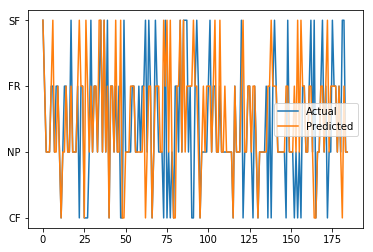

In [66]:
# Create plots comparing predictions with actual target
status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv(test_data)
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

In [67]:
status, model_type = ds.lookup_model_name(model_norm)
print(model_type['description']['best_genome'])

[{'layer 1': {'type': 'LinearGene', 'parameters': {'activation': 'leakyrelu', 'numunits': 92}}}, {'layer 2': {'type': 'LinearGene', 'parameters': {'activation': 'leakyrelu', 'numunits': 83}}}, {'layer 3': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 11}}}, {'layer 4': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 100}}}, {'layer 5': {'type': 'LinearGene', 'parameters': {'activation': 'relu', 'numunits': 52}}}, {'layer 6': {'type': 'LinearGene', 'parameters': {'activation': 'hardtanh', 'numunits': 6}}}]


This Seasons Predictions:
 - Currently, the NBA playoffs are in full swing. And with our newly created model, we thought it would be apt to test the results on these NBA playoffs.
 - The following cells upload the data from the 2019 NBA season, and display the expected results of each team.

In [71]:
target = 'Result'
new_season = "2019_season.csv"
model_std = target + "_model_norm"
new = pd.read_csv(new_season)
new["WIN_PCT"] = new['W'] / new['G']
new["NUM_TEAMS"] = 30
new["Result"] = ''

cols = [col for col in new.columns if col not in ['Team', 'Result', 'NUM_TEAMS', 'G', 'WIN_PCT']]
out = ['Team', 'Result', 'NUM_TEAMS', 'G', 'WIN_PCT']

norm_new = new[cols].transform(lambda x: ((x-x.min()) / (x.max() - x.min())))

norm_new[out] = new[out]

norm_new.head()

,Year,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,OFT/FGA,DeFG%,DTOV%,DRB%,DFT/FGA,Team,Result,NUM_TEAMS,G,WIN_PCT
0,NaN,0.529412,0.566667,0.770833,0.310345,0.557143,0.582090,0.365079,0.514563,0.603774,...,0.266667,0.622951,0.529412,0.500000,1.000000,Atlanta Hawks,,30,82,0.353659
1,NaN,0.264706,0.683333,0.635417,0.551724,0.500000,0.457711,0.571429,0.621359,0.660377,...,0.055556,0.180328,0.705882,0.576923,0.480000,Boston Celtics*,,30,82,0.597561
2,NaN,1.000000,0.383333,0.552083,0.275862,0.528571,0.542289,0.380952,0.427184,0.547170,...,0.477778,0.147541,0.176471,0.500000,0.373333,Brooklyn Nets*,,30,82,0.512195
3,NaN,0.441176,0.366667,0.562500,0.258621,0.400000,0.427861,0.349206,0.504854,0.650943,...,0.411111,0.573770,0.323529,0.589744,0.226667,Charlotte Hornets,,30,82,0.475610
4,NaN,0.705882,0.300000,0.364583,0.344828,0.000000,0.029851,0.349206,0.737864,0.943396,...,0.177778,0.622951,0.264706,0.615385,0.346667,Chicago Bulls,,30,82,0.268293


In [72]:
new_norm_name = 'norm_2019.csv'
norm_new.to_csv(path_or_buf = new_norm_name)

status, dataset = ds.upload_dataset(new_norm_name)
    
if not status:
    print(dataset)


status, job_id = ds.clean_data(new_norm_name, target = target, model_name = model_norm)

if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)


status, artifact = ds.run_model(new_norm_name, model_norm)
sleep(1)
ds.wait_for_job(artifact['job_name'])


status, prediction = ds.download_artifact(artifact['artifact_name'])




{'status': 'Taken', 'starttime': '2019-04-23T17:17:29.442664', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['norm_2019.csv'], 'artifact_names': ['e2e5f47aa74a4fed93b5012041ec004c'], 'model_name': None, 'job_error': None}
{'status': 'Complete', 'starttime': '2019-04-23T17:17:29.442664', 'endtime': '2019-04-23T17:17:31.095816', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['norm_2019.csv'], 'artifact_names': ['e2e5f47aa74a4fed93b5012041ec004c'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-23T17:17:45.755908', 'endtime': '2019-04-23T17:17:46.866472', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.7372937798500061, 'generations': 10, 'dataset_names': ['norm_2019.csv'], 'artifact_names': ['2b2843c529dd45bf9383b6ae5b62a3c0'], 'model_name': 'Result_model_norm', 'job_error': ''}
   Result       prob_CF   prob

In [81]:
prediction["Team"] = new["Team"]
prediction

,Result,prob_CF,prob_FR,prob_LF,prob_NP,prob_SF,prob_WF,Team
0,NP,1.690870e-05,0.024088,0.000002,0.974615,1.276412e-03,0.000001,Atlanta Hawks
1,SF,2.321938e-01,0.202003,0.133628,0.000860,3.522323e-01,0.079083,Boston Celtics*
2,FR,3.172368e-02,0.661225,0.012815,0.059731,2.276491e-01,0.006857,Brooklyn Nets*
3,FR,1.251951e-02,0.739976,0.003897,0.061708,1.800859e-01,0.001813,Charlotte Hornets
4,NP,5.000000e-10,0.000056,0.000000,0.999943,4.249000e-07,0.000000,Chicago Bulls
5,NP,0.000000e+00,0.000002,0.000000,0.999998,6.500000e-09,0.000000,Cleveland Cavaliers
6,NP,1.733457e-03,0.158901,0.000472,0.813644,2.492525e-02,0.000325,Dallas Mavericks
7,SF,2.097400e-01,0.247608,0.121023,0.002156,3.440186e-01,0.075454,Denver Nuggets*
8,FR,1.421150e-02,0.742534,0.004520,0.047515,1.891358e-01,0.002082,Detroit Pistons*
9,CF,2.648692e-01,0.157813,0.172520,0.005325,2.516929e-01,0.147780,Golden State Warriors*
